## Chapter Two

In [2]:
from fastai.vision.all import *

### Loading the Data

In [3]:
# downloading and unpacking the files
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
# setting the base path for convenience
Path.BASE_PATH = path

In [5]:
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [6]:
# inspect the mnist dataset
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [7]:
# load the files
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [8]:
# inspect one image
img3_path = threes[1]
img3 = Image.open(img3_path)
img3

In [10]:
array(img3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [11]:
# doing the same with a tensor
tensor(img3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [13]:
img3_t = tensor(img3)
df = pd.DataFrame(img3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


### Building a Baseline - Pixel Similarity

In [15]:
# load all the tensors
three_tensors = [tensor(Image.open(i)) for i in threes]
seven_tensors = [tensor(Image.open(i)) for i in sevens]
len(three_tensors), len(seven_tensors)

(6131, 6265)

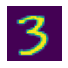

In [25]:
# use fastai function to display tensor as image
show_image(three_tensors[1]);

In [20]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

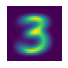

In [26]:
# calculate the mean over axis 0
three_mean = stacked_threes.mean(0)
show_image(three_mean);

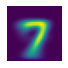

In [28]:
# also plot ideal seven
seven_mean = stacked_sevens.mean(0)
show_image(seven_mean);

Two ways of measuring distance in this context:
* Take the mean of the absolute value of differences (absolute value is the function that replaces negative values with positive values). This is called the mean absolute difference or L1 norm
* Take the mean of the square of differences (which makes everything positive) and then take the square root (which undoes the squaring). This is called the root mean squared error (RMSE) or L2 norm.

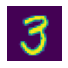

In [37]:
# take a sample three
three_sample = stacked_threes[2].float()
show_image(three_sample);

In [38]:
# calculate l1 norm to both means
l1_dist_3 = (three_sample-three_mean).abs().mean()
l1_dist_7 = (three_sample-seven_mean).abs().mean()
l1_dist_3, l1_dist_7

(tensor(0.1100), tensor(0.1541))

With l1 norm our sample image is closer to the ideal three which confirms our model.

In [39]:
# calculate l2 norm to both means
l2_dist_3 = ((three_sample-three_mean)**2).mean().sqrt()
l2_dist_7 = ((three_sample-seven_mean)**2).mean().sqrt()
l2_dist_3, l2_dist_7 

(tensor(0.1980), tensor(0.2974))

Also with the l2 norm our sample is closer to the ideal three which makes sense.

In [43]:
# there would be also pytorch function for these two losses
F.l1_loss(three_sample, three_mean), F.mse_loss(three_sample, three_mean).sqrt()

(tensor(0.1100), tensor(0.1980))

### Validating our Baseline Model

In [44]:
# loading the validation sets
valid_3_tensors = torch.stack([tensor(Image.open(i)) for i in (path/'valid'/'3').ls()])
valid_3_tensors = valid_3_tensors.float()/255
valid_7_tensors = torch.stack([tensor(Image.open(i)) for i in (path/'valid'/'7').ls()])
valid_7_tensors = valid_7_tensors.float()/255
valid_3_tensors.shape, valid_7_tensors.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [48]:
# creating our distance function
def mnist_distance(a, b): return (a-b).abs().mean((-1, -2))
mnist_distance(three_sample, three_mean)

tensor(0.1100)

In [49]:
valid_3_dist = mnist_distance(valid_3_tensors, three_mean)
valid_3_dist.shape, valid_3_dist

(torch.Size([1010]),
 tensor([0.1634, 0.1145, 0.1363,  ..., 0.1105, 0.1111, 0.1640]))

We took the mean over the last two axis and left just with the mean per images - thats why we have shape 1010 left.

#### Technical Sidenote - Broadcasting

In [69]:
test_tensor = valid_3_tensors[0][10:18, 10:15]
test_tensor

tensor([[0.0000, 0.0000, 0.0941, 0.4745, 0.7922],
        [0.5882, 0.7608, 0.8980, 0.9922, 0.9922],
        [0.9922, 0.9922, 0.9922, 0.9922, 0.9922],
        [0.9922, 0.9922, 0.9922, 0.9922, 0.9922],
        [0.9922, 0.9922, 0.9922, 0.9922, 0.8471],
        [0.9843, 0.9333, 0.5490, 0.2314, 0.0588],
        [0.3020, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

In [74]:
# you can specify the axis for the means
test_tensor.mean(), test_tensor.mean((-1)), test_tensor.mean((-2)), test_tensor.mean((-1,-2))

(tensor(0.5847),
 tensor([0.2722, 0.8463, 0.9922, 0.9922, 0.9631, 0.5514, 0.0604, 0.0000]),
 tensor([0.6064, 0.5838, 0.5647, 0.5843, 0.5843]),
 tensor(0.5847))

In [78]:
# you can abbreviate dimensions - they get 'copied'
tensor([2,3,4]) + tensor([1,1,1]), tensor([2,3,4]) + tensor([1])

(tensor([3, 4, 5]), tensor([3, 4, 5]))

In [97]:
# if you have stacked tensors
tensor_a = tensor([
    [.0,.0,.0],
    [.0,.0,.0],
    [.0,.0,.0],
    [.0,.0,.0]
])
tensor_b = tensor([
    [.1,.1,.1],
    [.1,.1,.1],
    [.1,.1,.1],
    [.1,.1,.1]
])
tensor_test = torch.stack((tensor_a, tensor_b))
tensor_test, tensor_test.shape

(tensor([[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],
 
         [[0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000]]]),
 torch.Size([2, 4, 3]))

In [98]:
# you can take operations over specific dimensions 
tensor_test.mean((-1,-2))

tensor([0.0000, 0.1000])

#### End Sidenote

In [101]:
# we define our prediction function
def is_3(x): return mnist_distance(x, three_mean) < mnist_distance(x, seven_mean)

# test our function
is_3(three_sample), is_3(seven_tensors[0])

(tensor(True), tensor(False))

In [104]:
# make the same with some partical function application - just for fun
dist_to_3 = bind(mnist_distance, three_mean)
dist_to_7 = bind(mnist_distance, seven_mean)

def is_3(x): return dist_to_3(x) < dist_to_7(x)

# test our function
is_3(three_sample), is_3(seven_tensors[0])

(tensor(True), tensor(False))

In [107]:
# now lets evaluate the accuracy of our baseline model
accuracy_3s = is_3(valid_3_tensors).float().mean()
accuracy_7s = (1 - is_3(valid_7_tensors).float()).mean()
accuracy_3s, accuracy_7s

(tensor(0.9168), tensor(0.9854))

In [109]:
# and take overall accuracy
tensor(accuracy_3s, accuracy_7s).mean()

tensor(0.9511)

With our trivial classifier we already reached an acc of 95%! But these is only for two out of 10 digits. Maybe we need to implement some real learning.